# Projeto final de Aprendizado de Máquina: análise e predição de dados clínicos
## UFMG - 2023/1 - Professor Adriano Veloso
### Luís Felipe Ramos Ferreira - 2019022553

Link para apresentação no youtube: link

# Introdução

O projeto final implementado e apresentado neste *notebook* apresenta a aplicação de conceitos e algoritmos de Aprendizado de Máquina em um contexto da área da saúde. Mais especificamente, os dados utilizados foram fornecidos por uma equipe ligada ao Hospital das Clínicas de Belo Horizonte e representam condições e características relacionadas a pacientes internados nos hospitais, como apresentação de comorbidades, resultados de exames fisiológicos, complicações durante internação, etc.

O objetivo principal com a utilização destes dados é prever, a partir destas informações, o período de tempo que o paciente irá ficar internado na UTI (Unidade de Tratamento Intensivo), de modo que os custos e equipamentos possam ser redirecionados da maneira correta e, dessa maneira, o maior número de vidas possam ser salvas.

Nesse cenário, duas abordagens podem ser levados em consideração. Como o tempo de internação na UTI esta presente nos dados como uma variável numérica, pode-se lidar coma  situação como um problema de regressão. No entanto, para aumentar o paradigma de estuda, podemos discretizar os dados relativos ao tempo de internação, em categorias que separam os pacientes entre aqueles ue ficaram mais ou menos que 3 dias internados, por exemplo. Assim, vários algoritmos e abordagens diferentes podem ser analisados.

Em resumo, o problema consiste em, possuindo dados relativos à admissão de um apciente no hospital, como dados de comorbidades, idade, dados fisiológicos de exames, etc, seja possível fazer uma previsão adequada do tempo que o paciente ficará internado na UTI. Naturalmente, este é um problema difícil, mas com grande importância em uma escala global.

# Metodologia

Um vasto conjunto de algoritmos e técnicas foi utilizado de forma supervisionada, desde modelos tradicionais e introdutórios até redes neurais mais complexas, para que um _benchmark_ entre todas as abordagens pudesse ser feito. Em particular, foram testadas abordagens como:

- _Random Forest_
- _SVM (Support Vector Machine)_
- _Naive Bayes_
- _XGBoost_


# Bibliotecas utilizadas no desenvolvimento

In [198]:
import os
import sys
import json
import time
import random

import numpy as np
import pandas as pd
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import xgboost as xgb
import tensorflow as tf

# Constantes

Aqui estão as definições de algumas constantes que são utilizadas no decorres do código. Em particular, as constantes _MAXIMUM_UNIT_LENGTH_STAY_ e _NUMBER_OF_BINS_ dizem respeito à forma como os dados de tempo de permanência serão discretizados.

In [199]:
RANDOM_STATE: np.int8 = 42
TEST_SIZE: np.float64 = 0.2

MAXIMUM_UNIT_LENGTH_STAY: np.int32 = 300
BINS: list[int] = [0, 1, MAXIMUM_UNIT_LENGTH_STAY]

# Engenharia de dados

Aqui é feita a engenharia de dados de todos os arquivos __csv__ que são utilizados no projeto, de modo que ao final, três _dataframes_ são criados. Um deles, denominado _final_data_, contêm todas as _features_ utilziadas durante a construção dos modelos. Os _dataframes_ denominados _labels_regression_ e _labels_classification_ contêm respectivamente, as _labels_ utilizadas durante o treino e teste de cada um dos tipos de modelo de aprendizado de máquina utilizados.

In [200]:
# getting data from comorbidades and capacidade funcional, plus ages and labels
df: pd.DataFrame = pd.read_csv("data/raw/folha3.csv")
ages: pd.Series = df["Age"].copy()
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
labels: pd.DataFrame = df["UnitLengthStay"].copy()
df = df.iloc[:, 22:]
sheet_3_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from motivos de internação na UTI
df = pd.read_csv("data/raw/folha4.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_4_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from complicações no primeiro dia na uti
df = pd.read_csv("data/raw/folha5.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_5_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from dados fisiologicos na UTI
df = pd.read_csv("data/raw/folha6.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_6_df: pd.DataFrame = df.copy()

# joining dataframes into final data
final_data: pd.DataFrame = pd.concat([ages, sheet_3_df, sheet_4_df], axis=1, join="inner") # rever se sheet5 pode ser adicionada

labels_regression: pd.DataFrame = labels.copy()
labels_classification: pd.DataFrame = pd.cut(x=labels_regression, bins=BINS, labels=np.arange(len(BINS) - 1))

# Utilitários

Aqui são definidas alguams funções utilitárias para o desenvolvimento do projeto de forma geral.

In [201]:
def get_run_info(
    y_true: npt.NDArray[np.float64],
    y_pred: npt.NDArray[np.float64],
    type: np.str_ = "classification",
    dump: np.bool_ = False,
    plot_confusion_matrix: bool = False,
) -> dict:
    if type == "classification":
        accuracy_score: np.float64 = metrics.accuracy_score(
            y_true=y_true, y_pred=y_pred
        )
        precision_score: np.float64 = metrics.precision_score(
            y_true=y_true, y_pred=y_pred
        )
        recall_score: np.float64 = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        f1_score: np.float64 = metrics.f1_score(y_true=y_true, y_pred=y_pred)
        confusion_matrix: npt.NDArray[np.int32] = metrics.confusion_matrix(
            y_true=y_true, y_pred=y_pred
        )

        run_info: dict = {
            "accuracy_score": accuracy_score,
            "precision_score": precision_score,
            "recall_score": recall_score,
            "f1_score": f1_score,
            "confusion_matrix": confusion_matrix,
        }

        if plot_confusion_matrix:
            metrics.ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix,
                display_labels=["Um dia na UTI", "Mais que um dia na UTI"],
            ).plot()

    else:  # regression
        mean_squared_error: np.float64 = metrics.mean_squared_error(
            y_true=y_true, y_pred=y_pred
        )
        root_mean_squared_error: np.float64 = metrics.mean_squared_error(
            y_true=y_true, y_pred=y_pred, squared=False
        )
        mean_absolute_error: np.float64 = metrics.mean_absolute_error(
            y_true=y_true, y_pred=y_pred
        )

        run_info: dict = {
            "mean_squared_error": mean_squared_error,
            "root_mean_squared_error": root_mean_squared_error,
            "mean_absolute_error": mean_absolute_error,
        }

    if dump:
        with open(f"{type}_run_info{time.time()}") as file:
            json.dump(run_info, file, indent=4)

    return run_info


def reset_seeds() -> None:
    SEED: np.int8 = 42
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Ambiente de desenvolvimento

Os códigos disponiblizados abaixo foram desenvolvidos no meu computador local em um ambiente _Anaconda_, cujas configurações estão disponibilizadas no arquivos _environment.yml_, juntamente das versões dos pacotes utilizados. A versão da linguagem _Python_ utilizada foi a 3.11.3.

INSTRUÇÕES DE COMO RODAR TUDO

# Análise exploratória do conjunto de dados utilizado

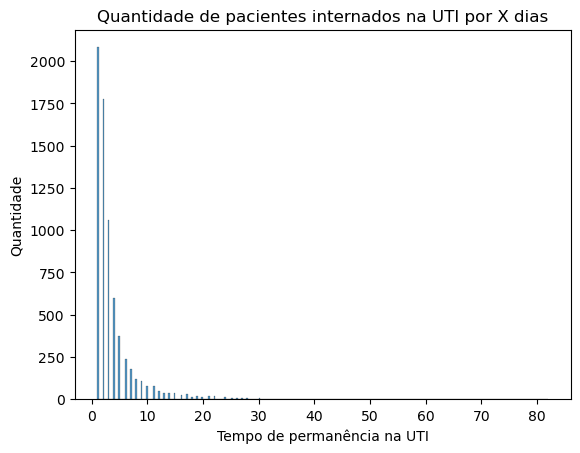

In [202]:
plt.title("Quantidade de pacientes internados na UTI por X dias")
ax = sns.histplot(data=labels_regression)
ax.set_ylabel("Quantidade")
ax.set_xlabel("Tempo de permanência na UTI")
None

No caso discretizado, as classes são definidas de acordo com os parâmetros iniciais escolhidos no início da implementação. Em particular, por consião, optou-se por separar os pacientes em duas classes discretas de tempo de permanência na UTI. As classes são:

- 0: Pacientes que ficaram um dia na UTI
- 1: Pacientes que ficaram mais do que um dia na UTI

Essa escolha foi feita com base nof ato de que a base de dados é extremamente desbalanceada, e grande parte dos pacientes presentes nela ficaram apenas 1 dia na UTI, como podemos ver no gráfico acima.

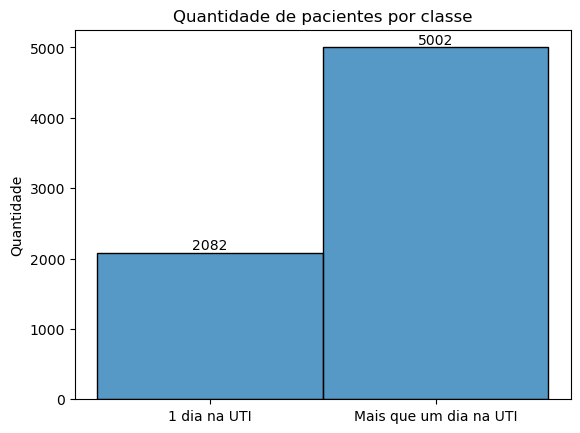

In [203]:
plt.title("Quantidade de pacientes por classe")
ax = sns.histplot(data=labels_classification)
for rect in ax.patches:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
    )
ax.set_xlabel(None)
ax.set_ylabel("Quantidade")
ax.set_xticks(ticks=np.arange(len(BINS) - 1))
ax.set_xticklabels(["1 dia na UTI", "Mais que um dia na UTI"])
None

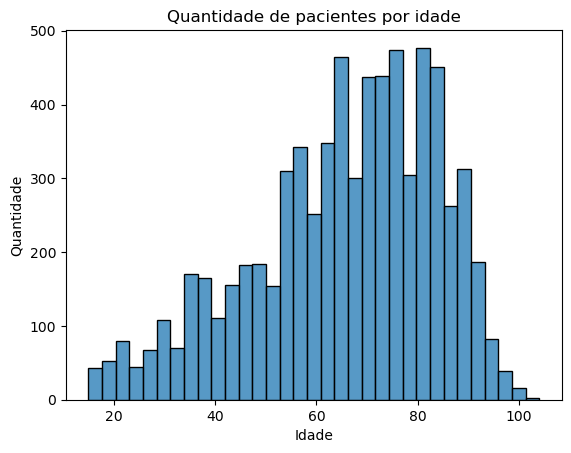

In [204]:
plt.title("Quantidade de pacientes por idade")
ax = sns.histplot(data=final_data["Age"])
ax.set_xlabel("Idade")
ax.set_ylabel("Quantidade")
None

A distribuição de idade dos pacientes parece claramente seguir uma distribuição normal centrada por volta de 75 anos de idade. Como sabe-se, pessoas mais velhas possuem mais comorbidades e possuem maior chance de precisarem de um tratamento longo em uma unidade de tratamento intensivo.

# Regressão

In [205]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data, labels_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
NUMBER_OF_ESTIMATORS: np.int32 = 100

In [206]:
model = RandomForestRegressor(n_estimators=NUMBER_OF_ESTIMATORS, max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred, type="regression")

{'mean_squared_error': 24.509689332709662,
 'root_mean_squared_error': 4.950726141962375,
 'mean_absolute_error': 2.6567696512265697}

In [207]:
model = xgb.XGBRegressor(n_estimators=NUMBER_OF_ESTIMATORS, n_jobs=-1, colsample_bytree=0.7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_true=y_test, y_pred=y_pred, type="regression")

{'mean_squared_error': 26.247765386161642,
 'root_mean_squared_error': 5.123257302357714,
 'mean_absolute_error': 2.7466832786488253}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

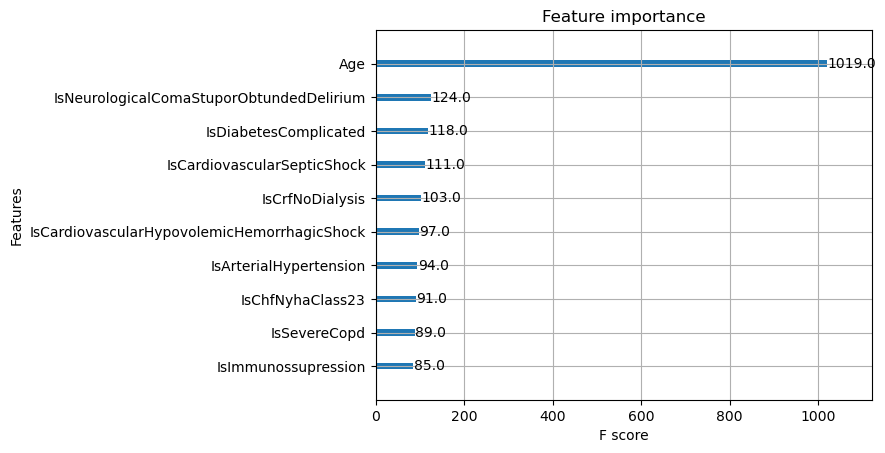

In [208]:
xgb.plot_importance(booster=model, max_num_features=10)

# Classificação

Como reiterado anteriormente, diversos algoritmos de classificação serão utilizados para analisar a performance dentro da base de dados apresentada. Diversos modelos clássicos serão testados e, posteriormente, alguns modelos mais complexos e atuais de _boosting_ também serão analisados.

In [209]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data, labels_classification, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## _Support Vector Machine_ (SVM)

{'accuracy_score': 0.5638673253352152,
 'precision_score': 0.6733266733266733,
 'recall_score': 0.6984455958549223,
 'f1_score': 0.6856561546286876,
 'confusion_matrix': array([[125, 327],
        [291, 674]])}

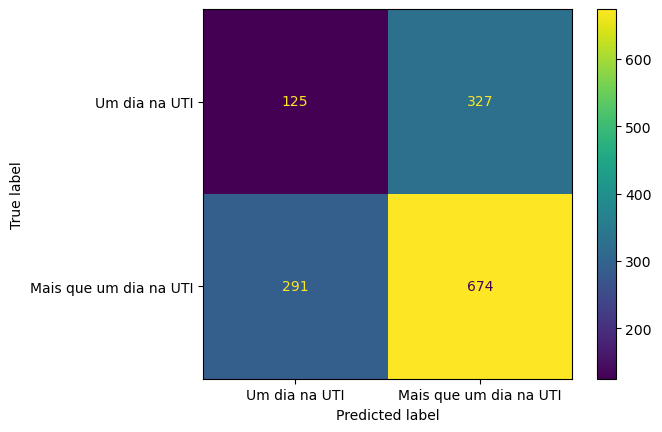

In [210]:
model = SVC(probability=True, kernel="sigmoid")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred, plot_confusion_matrix=True)

{'accuracy_score': 0.681016231474947,
 'precision_score': 0.681016231474947,
 'recall_score': 1.0,
 'f1_score': 0.8102434928631402,
 'confusion_matrix': array([[  0, 452],
        [  0, 965]])}

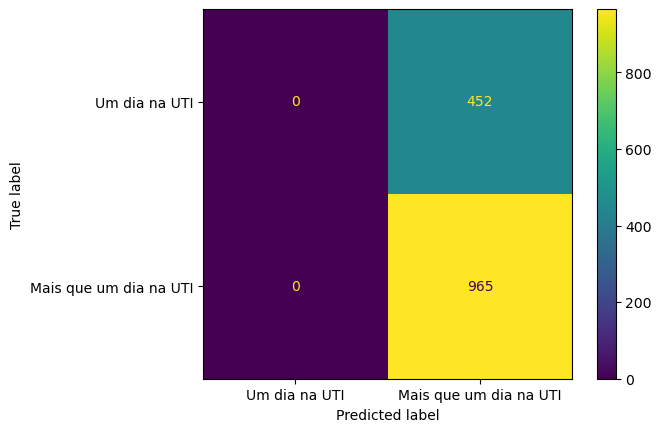

In [211]:
model = SVC(degree=3, probability=True, kernel="poly")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred, plot_confusion_matrix=True)

## _Naive Bayes_

{'accuracy_score': 0.4883556810162315,
 'precision_score': 0.7884615384615384,
 'recall_score': 0.3398963730569948,
 'f1_score': 0.47501810282404056,
 'confusion_matrix': array([[364,  88],
        [637, 328]])}

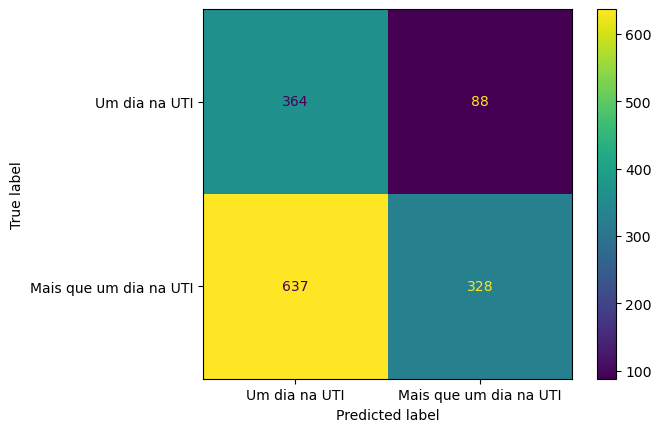

In [212]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred, plot_confusion_matrix=True)

## _Random Forest_

O modelo classificador de [_Random Forest_](https://en.wikipedia.org/wiki/Random_forest) utilizado foi o da biblioteca [_Scikit Learn_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

{'accuracy_score': 0.6640790402258292,
 'precision_score': 0.7080851063829787,
 'recall_score': 0.8621761658031089,
 'f1_score': 0.7775700934579439,
 'confusion_matrix': array([[109, 343],
        [133, 832]])}

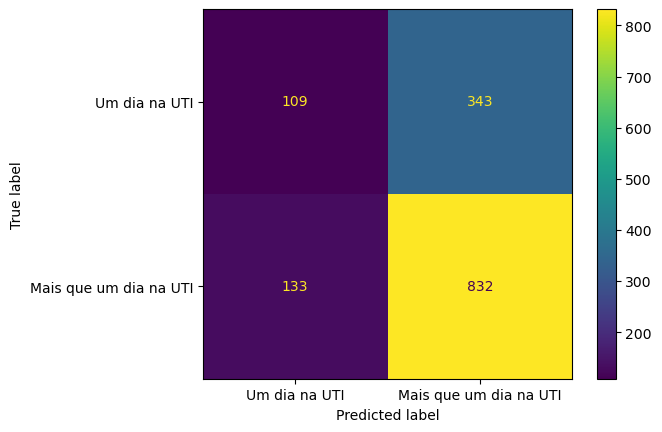

In [213]:
NUMBER_OF_ESTIMATORS: np.int32 = 100
model = RandomForestClassifier(
    n_estimators=NUMBER_OF_ESTIMATORS, random_state=RANDOM_STATE, max_depth=50
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_true=y_test, y_pred=y_pred, plot_confusion_matrix=True)

## _XGBoost_

{'accuracy_score': 0.6725476358503881,
 'precision_score': 0.701853344077357,
 'recall_score': 0.9025906735751296,
 'f1_score': 0.7896645512239346,
 'confusion_matrix': array([[ 82, 370],
        [ 94, 871]])}

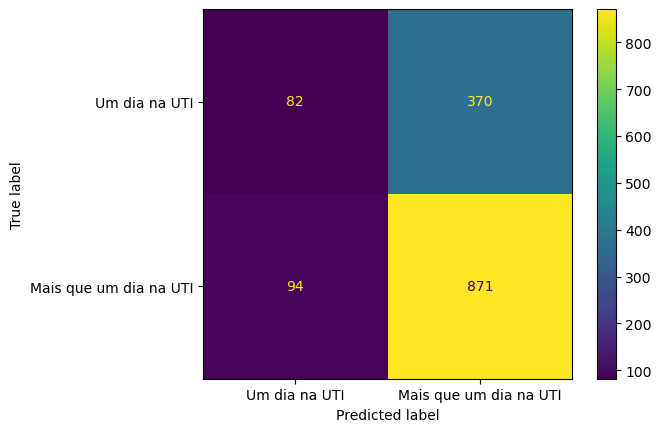

In [214]:
model = xgb.XGBClassifier(
    n_estimators=NUMBER_OF_ESTIMATORS,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_true=y_test, y_pred=y_pred, plot_confusion_matrix=True)

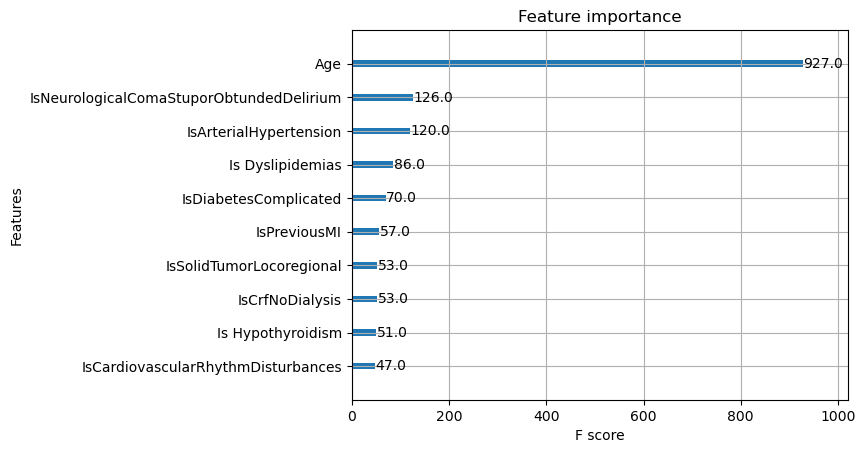

In [215]:
xgb.plot_importance(booster=model, max_num_features=10)
None

Referencias

https://arxiv.org/pdf/1603.02754.pdf
